In [1]:
import numpy as np
import time
import progressbar
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import SimpleITK as sitk
import scipy.misc as misc
import scipy.ndimage as snd
import imageio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import h5py
%matplotlib inline

In [2]:
class UNet(nn.Module):
    
    def __init__(self):
        
        super(UNet, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        
        self.upconv1 = nn.Sequential(nn.ConvTranspose2d(128,128,stride=2, kernel_size=2), nn.BatchNorm2d(128))
        self.conv5 = nn.Sequential(nn.Conv2d(128,64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        
        self.upconv2 = nn.Sequential(nn.ConvTranspose2d(128,32,stride=2, kernel_size=2), nn.BatchNorm2d(32))
        self.conv6 = nn.Sequential(nn.Conv2d(32,2, kernel_size=3, padding=1), nn.BatchNorm2d(2))
        
    def forward(self, x):
        
        x = F.relu(self.conv2(F.relu(self.conv1(x))), inplace=True)
        x_0 = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv4(F.relu(self.conv3(x_0))), inplace=True)
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv5(F.relu(self.upconv1(x))))
        x = torch.cat([x,x_0], 1)
        x = self.conv6(F.relu(self.upconv2(x)))
        x = F.log_softmax(x, dim=1)
        
        return x

In [4]:
class SimpleTrainer(object):
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
    def forward_backward(self,inputs, labels):
        self.inputs = inputs
        self.labels = labels
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        inputs = Variable(inputs) #.cuda()
        labels = Variable(labels) #.cuda()
        self.optimizer.zero_grad()
        outputs = self.model.forward(inputs)
        loss = self.loss_fn(outputs, labels)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def forward(self ,inputs, labels):
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        inputs = Variable(inputs, volatile=True) #.cuda()
        labels = Variable(labels, volatile=True) #.cuda()
        outputs = self.model.forward(inputs)
        loss = self.loss_fn(outputs, labels)
        return loss.item()

In [5]:
EPOCHS = 100  # Number of iterations for training the newtork
BATCH_SIZE = 48  # Number of training example to be fed to the network
PATCH_SIZE = [128,128]  # the input size of the image (L*B)

In [6]:
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=5e-5)
trainer = SimpleTrainer(model,nn.NLLLoss2d(), optimizer) 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:210: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


In [7]:
state = torch.load('/home/ryan/ImageSegmentationMedical/data/pertained_models/u-net_cpu.tar')['state_dict']
model = UNet() #.cuda()
model.load_state_dict(state)


<All keys matched successfully>

In [8]:
def display_image_label_and_output(image, label, output):
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(image, cmap = 'gray')
    plt.subplot(1,3,2)
    plt.imshow(image, cmap = 'gray')
    plt.imshow(label, alpha = 0.5)
    plt.subplot(1,3,3)
    plt.imshow(output, cmap = 'gray')
    plt.imshow(label, alpha = 0.5)
    plt.show() 

In [14]:
def predict(model , image , label):
        inputs = Variable(torch.from_numpy(image.reshape(1,1,128,128))) #.cuda()
        inputs = inputs.float()
        out = model.forward(inputs)
        out = np.argmax(out.data.cpu().numpy(), axis=1).reshape(128,128)
        display_image_label_and_output(image, label, out)

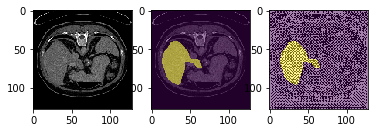

In [15]:
img_arr = imageio.imread('/home/ryan/ImageSegmentationMedical/data/test_images/img1.png')

label_arr = imageio.imread('/home/ryan/ImageSegmentationMedical/data/test_images/label1.png')

predict(UNet() , img_arr ,label_arr)